In [44]:
import pandas as pd
from statistics import mean, stdev
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import datetime as dt

In [ ]:
df = pd.read_csv(r" training data ") #VIX data from CBOE from 2004 to 2019 to predict 2020, available on official CBOE website
df.tail()

In [ ]:
df.head()

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['VIX Open'],
                high=df['VIX High'],
                low=df['VIX Low'],
                close=df['VIX Close'])])
fig.show()

In [5]:
stat_matrix = [] # enum 0 to 3: open, high, low, close
content = [df['VIX Open'], df['VIX High'], df['VIX Low'], df['VIX Close']]
for i in range(4):
        stat_matrix.append([min(content[i]), max(content[i]), mean(content[i]), stdev(content[i])])

In [4]:
training_set = df.iloc[:, 1:2].values #extracting VIX Open values for training

In [5]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set) #
training_set_scaled

array([[0.12477346],
       [0.13160463],
       [0.12059111],
       ...,
       [0.05785585],
       [0.0549282 ],
       [0.04712115]])

In [22]:
X_train = []
y_train = []
for i in range(100, 3998): #making memory window length 100 i.e. 100 values of OPEN 0-100 in sequence will map to one value of OPEN ie 100
    X_train.append(training_set_scaled[i - 100 : i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
# X_train.shape = (3938, 100) , y_train.shape = (3938,)
# print(X_train.shape) ; (3898, 100)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#print(X_train.shape) #>> (3898, 100, 1) ; 3938 arrays of 100 * 1 will be input for the LSTM layer

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2)) #avoid overfitting

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2)) #avoid overfitting

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2)) #avoid overfitting

model.add(LSTM(units = 50))
model.add(Dropout(0.2)) #avoid overfitting

model.add(Dense(units = 1)) #op

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
dataset_test = pd.read_csv(r" testing model ") # received from CBOE website #test data is from Nov 19 2019 to Aug end 2020
observed_VIX = dataset_test.iloc[:, 1:2].values
observed_VIX.shape

In [ ]:
dataset_total = pd.concat((df['VIX Open'], dataset_test['VIX Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 100 :].values
print (inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(100, 297):
    X_test.append(inputs[i - 100 : i, 0])
X_test = np.array(X_test)
print (inputs.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_VIX = model.predict(X_test)
predicted_VIX = sc.inverse_transform(predicted_VIX) #since we want the original values

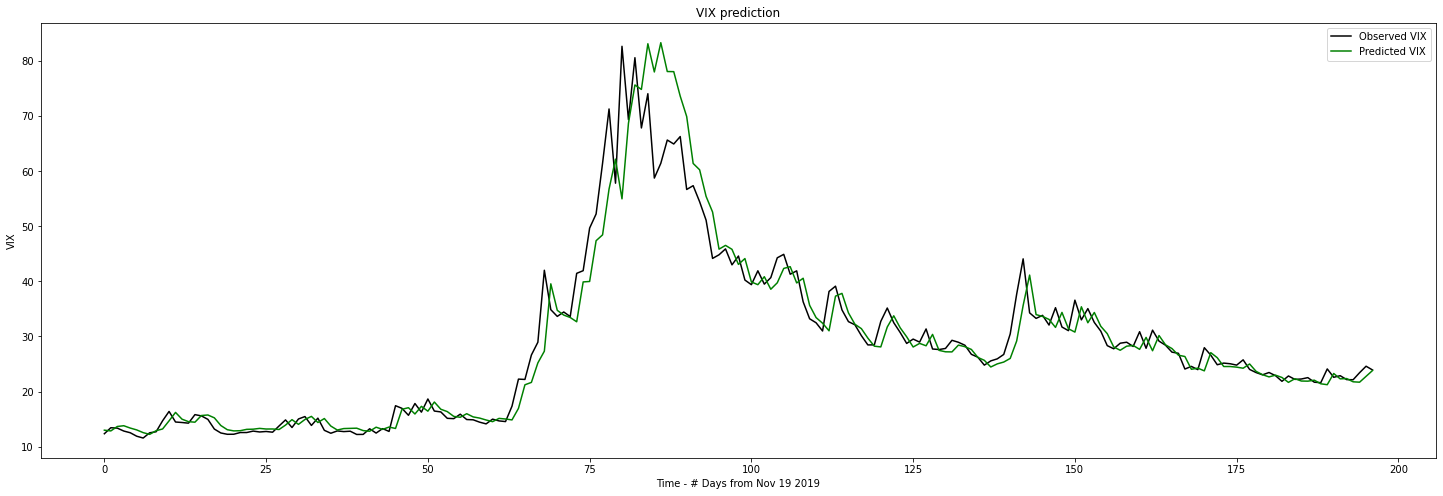

In [45]:
plt.plot(observed_VIX, color = 'black', label = 'Observed VIX')
plt.plot(predicted_VIX, color = 'green', label = 'Predicted VIX')
plt.title('VIX prediction')
plt.xlabel('Time - # Days from Nov 19 2019')
plt.ylabel('VIX')
plt.legend()
figsize(25, 8)
plt.show()